In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools

# Setting random seeds ensures that the results are the same every time you run the code.
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check if a GPU is available to speed up training; otherwise, use CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device selected: {device}')

Device selected: cpu


In [ ]:
# 2. DATA PREPARATION (CIFAR-10)
# Define transformations: Convert images to PyTorch Tensors and Normalize them.
# Normalization helps the model train faster and more stably.
# (0.5, 0.5, 0.5) are the Mean and Std Dev for the 3 RGB channels.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Download and load the training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Download and load the test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Define the class names for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
# 3. LeNet-5 ARCHITECTURE IMPLEMENTATION
class LeNetDynamic(nn.Module):
    def __init__(self, activation_fn):
        super(LeNetDynamic, self).__init__()

        # We store the activation function (ReLU or Sigmoid) to use it dynamically
        self.activation_fn = activation_fn

        # Layer 1: Convolution
        # Input: 3 input channels (Red, Green, Blue) because CIFAR-10 is color.
        # Output: 6 feature maps.
        # Kernel size: 5x5.
        self.conv1 = nn.Conv2d(3, 6, 5)

        # Layer 2: Convolution
        # Input: 6 input channels (from prev layer).
        # Output: 16 feature maps.
        # Kernel size: 5x5.
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully Connected Layers
        # Calculation for input size:
        # Original Image: 32x32
        # After Conv1 (5x5 filter): 28x28 -> After MaxPool (2x2): 14x14
        # After Conv2 (5x5 filter): 10x10 -> After MaxPool (2x2): 5x5
        # Flattened size = 16 channels * 5 * 5 pixels = 400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # Output layer: 10 classes

    def forward(self, x):
        # Apply Conv1 -> Activation -> MaxPool
        x = F.max_pool2d(self.activation_fn(self.conv1(x)), 2)

        # Apply Conv2 -> Activation -> MaxPool
        x = F.max_pool2d(self.activation_fn(self.conv2(x)), 2)

        # Flatten the multi-dimensional tensor to a 1D vector
        x = x.view(-1, 16 * 5 * 5)

        # Fully connected layers with activation
        x = self.activation_fn(self.fc1(x))
        x = self.activation_fn(self.fc2(x))

        # Output layer (No activation function here, handled by Loss function)
        x = self.fc3(x)
        return x

In [ ]:
def run_experiment(activation_name, activation_fn, batch_size, loss_name, criterion, optimizer_name, optimizer_class, epochs=5):
    """
    Runs a single training and testing experiment with the given configuration.
    """
    print(f"\n{'='*60}")
    print(f"STARTING EXPERIMENT: Act={activation_name} | Batch={batch_size} | Loss={loss_name} | Opt={optimizer_name}")
    print(f"{'='*60}")

    # Create new DataLoaders for each experiment to handle different Batch Sizes (8 or 64)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Send the model to the GPU/CPU
    net = LeNetDynamic(activation_fn).to(device)

    # SGD usually requires momentum for better convergence
    if optimizer_name == "SGD":
        optimizer = optimizer_class(net.parameters(), lr=0.001, momentum=0.9)
    else: # For Adam, we typically use the default learning rate
        optimizer = optimizer_class(net.parameters(), lr=0.001)

    # 4. Training Loop
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients before backpropagation
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Loss Calculation
            if loss_name == "MSE":
                # MSE Loss requires the target to be One-Hot Encoded and Float type.
                # Example: Class 3 becomes [0, 0, 0, 1, 0, ...]
                labels_one_hot = F.one_hot(labels, num_classes=10).float()
                loss = criterion(outputs, labels_one_hot)
            else:
                # CrossEntropyLoss expects class indices (long) directly.
                loss = criterion(outputs, labels)


            # Backward pass (compute gradients)
            loss.backward()

            # Optimize (update weights)
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs} completed. Loss: {running_loss/len(trainloader):.4f}")

    # 5. Testing Phase
    all_preds = []
    all_labels = []
    correct = 0
    total = 0


    # No gradient needed for testing (saves memory)
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)

            # The class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect all predictions for the Confusion Matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"\n--> Experiment Result Accuracy: %{accuracy:.2f}")

    # 6. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f"Act:{activation_name} Batch:{batch_size}\nLoss:{loss_name} Opt:{optimizer_name}\nAcc: %{accuracy:.2f}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return accuracy

Total of 16 different configurations will be tested.

STARTING EXPERIMENT: Act=ReLU | Batch=8 | Loss=CrossEntropy | Opt=SGD
Epoch 1/10 completed. Loss: 1.8577
Epoch 2/10 completed. Loss: 1.4258
Epoch 3/10 completed. Loss: 1.2505
Epoch 4/10 completed. Loss: 1.1386
Epoch 5/10 completed. Loss: 1.0544
Epoch 6/10 completed. Loss: 0.9909
Epoch 7/10 completed. Loss: 0.9359
Epoch 8/10 completed. Loss: 0.8924
Epoch 9/10 completed. Loss: 0.8466
Epoch 10/10 completed. Loss: 0.8112

--> Experiment Result Accuracy: %64.94


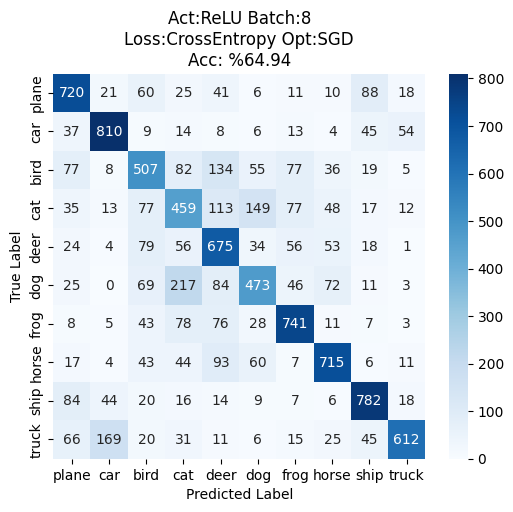


STARTING EXPERIMENT: Act=ReLU | Batch=8 | Loss=CrossEntropy | Opt=Adam
Epoch 1/10 completed. Loss: 1.5322
Epoch 2/10 completed. Loss: 1.2513
Epoch 3/10 completed. Loss: 1.1433
Epoch 4/10 completed. Loss: 1.0737
Epoch 5/10 completed. Loss: 1.0191
Epoch 6/10 completed. Loss: 0.9717
Epoch 7/10 completed. Loss: 0.9328
Epoch 8/10 completed. Loss: 0.8979
Epoch 9/10 completed. Loss: 0.8720
Epoch 10/10 completed. Loss: 0.8477

--> Experiment Result Accuracy: %62.73


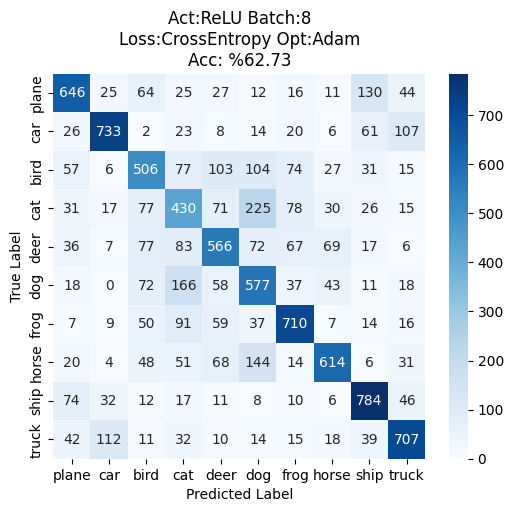


STARTING EXPERIMENT: Act=ReLU | Batch=8 | Loss=MSE | Opt=SGD
Epoch 1/10 completed. Loss: 0.0885
Epoch 2/10 completed. Loss: 0.0827
Epoch 3/10 completed. Loss: 0.0793
Epoch 4/10 completed. Loss: 0.0771
Epoch 5/10 completed. Loss: 0.0755
Epoch 6/10 completed. Loss: 0.0740
Epoch 7/10 completed. Loss: 0.0727
Epoch 8/10 completed. Loss: 0.0714
Epoch 9/10 completed. Loss: 0.0701
Epoch 10/10 completed. Loss: 0.0689

--> Experiment Result Accuracy: %47.02


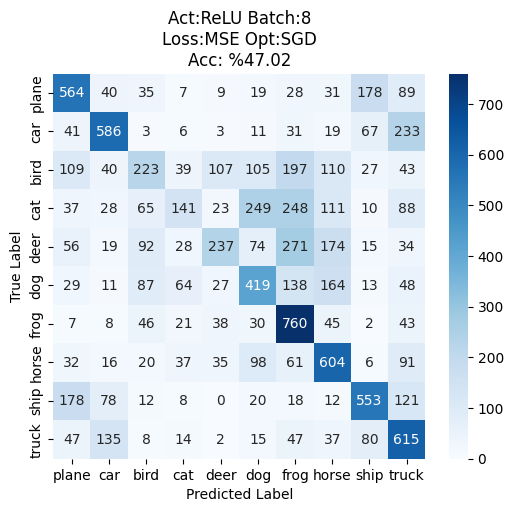


STARTING EXPERIMENT: Act=ReLU | Batch=8 | Loss=MSE | Opt=Adam
Epoch 1/10 completed. Loss: 0.0682
Epoch 2/10 completed. Loss: 0.0586
Epoch 3/10 completed. Loss: 0.0549
Epoch 4/10 completed. Loss: 0.0523
Epoch 5/10 completed. Loss: 0.0502
Epoch 6/10 completed. Loss: 0.0488
Epoch 7/10 completed. Loss: 0.0474
Epoch 8/10 completed. Loss: 0.0463
Epoch 9/10 completed. Loss: 0.0453
Epoch 10/10 completed. Loss: 0.0444

--> Experiment Result Accuracy: %62.26


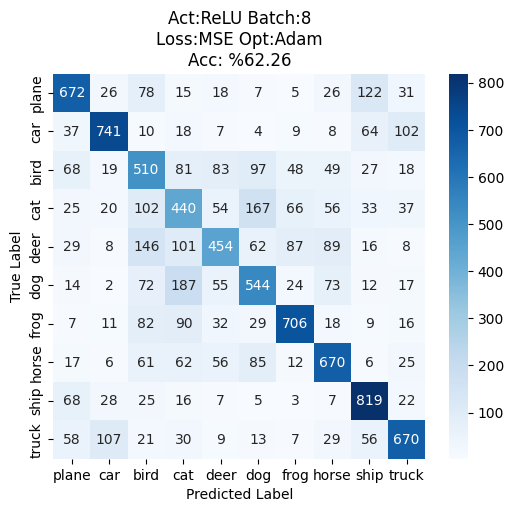


STARTING EXPERIMENT: Act=ReLU | Batch=64 | Loss=CrossEntropy | Opt=SGD
Epoch 1/10 completed. Loss: 2.2993
Epoch 2/10 completed. Loss: 2.2112
Epoch 3/10 completed. Loss: 2.0206
Epoch 4/10 completed. Loss: 1.7858
Epoch 5/10 completed. Loss: 1.6452
Epoch 6/10 completed. Loss: 1.5538
Epoch 7/10 completed. Loss: 1.4848
Epoch 8/10 completed. Loss: 1.4288
Epoch 9/10 completed. Loss: 1.3775
Epoch 10/10 completed. Loss: 1.3212

--> Experiment Result Accuracy: %52.67


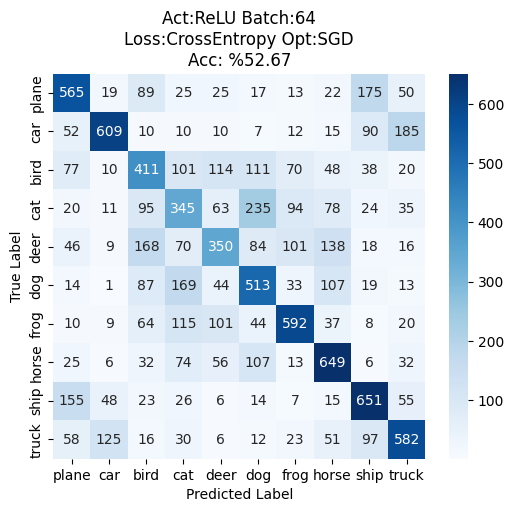


STARTING EXPERIMENT: Act=ReLU | Batch=64 | Loss=CrossEntropy | Opt=Adam
Epoch 1/10 completed. Loss: 1.6493
Epoch 2/10 completed. Loss: 1.3621
Epoch 3/10 completed. Loss: 1.2428
Epoch 4/10 completed. Loss: 1.1584
Epoch 5/10 completed. Loss: 1.0987
Epoch 6/10 completed. Loss: 1.0451
Epoch 7/10 completed. Loss: 0.9999
Epoch 8/10 completed. Loss: 0.9655
Epoch 9/10 completed. Loss: 0.9267
Epoch 10/10 completed. Loss: 0.9005

--> Experiment Result Accuracy: %62.70


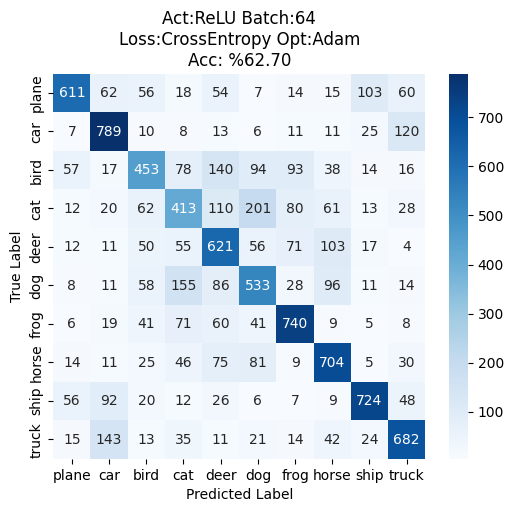


STARTING EXPERIMENT: Act=ReLU | Batch=64 | Loss=MSE | Opt=SGD
Epoch 1/10 completed. Loss: 0.0947
Epoch 2/10 completed. Loss: 0.0897
Epoch 3/10 completed. Loss: 0.0893
Epoch 4/10 completed. Loss: 0.0889
Epoch 5/10 completed. Loss: 0.0884
Epoch 6/10 completed. Loss: 0.0879
Epoch 7/10 completed. Loss: 0.0874
Epoch 8/10 completed. Loss: 0.0870
Epoch 9/10 completed. Loss: 0.0865
Epoch 10/10 completed. Loss: 0.0861

--> Experiment Result Accuracy: %25.22


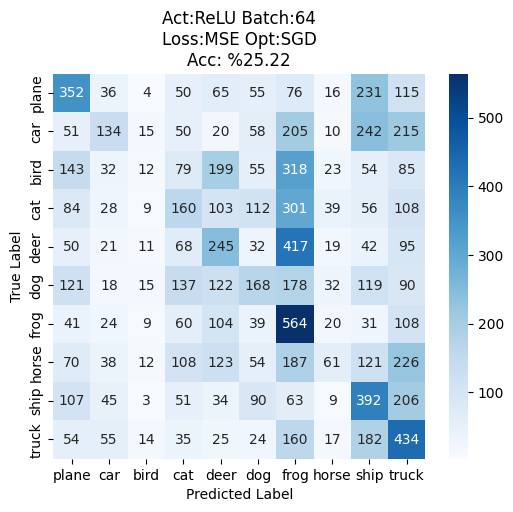


STARTING EXPERIMENT: Act=ReLU | Batch=64 | Loss=MSE | Opt=Adam
Epoch 1/10 completed. Loss: 0.0716
Epoch 2/10 completed. Loss: 0.0607
Epoch 3/10 completed. Loss: 0.0558
Epoch 4/10 completed. Loss: 0.0522
Epoch 5/10 completed. Loss: 0.0497
Epoch 6/10 completed. Loss: 0.0478
Epoch 7/10 completed. Loss: 0.0462
Epoch 8/10 completed. Loss: 0.0449
Epoch 9/10 completed. Loss: 0.0437
Epoch 10/10 completed. Loss: 0.0425

--> Experiment Result Accuracy: %62.47


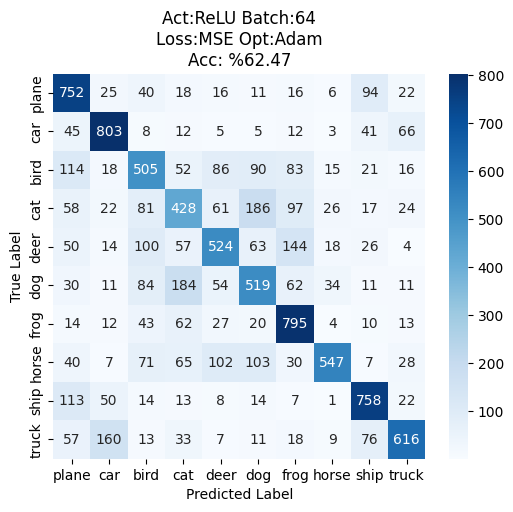


STARTING EXPERIMENT: Act=Sigmoid | Batch=8 | Loss=CrossEntropy | Opt=SGD
Epoch 1/10 completed. Loss: 2.3088
Epoch 2/10 completed. Loss: 2.3084
Epoch 3/10 completed. Loss: 2.3074
Epoch 4/10 completed. Loss: 2.3071
Epoch 5/10 completed. Loss: 2.3061
Epoch 6/10 completed. Loss: 2.3059
Epoch 7/10 completed. Loss: 2.3054
Epoch 8/10 completed. Loss: 2.3051
Epoch 9/10 completed. Loss: 2.3048
Epoch 10/10 completed. Loss: 2.3046

--> Experiment Result Accuracy: %10.00


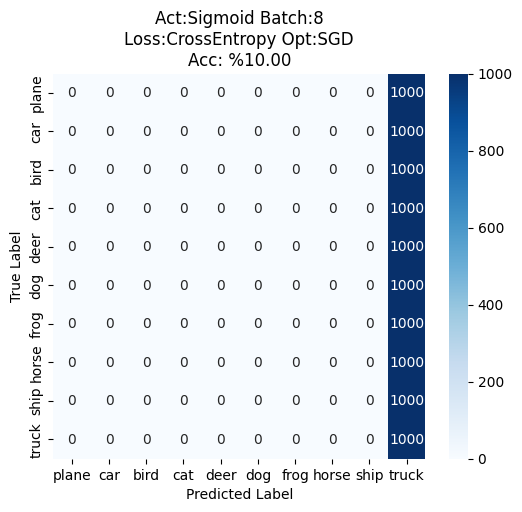


STARTING EXPERIMENT: Act=Sigmoid | Batch=8 | Loss=CrossEntropy | Opt=Adam
Epoch 1/10 completed. Loss: 1.8886
Epoch 2/10 completed. Loss: 1.5834
Epoch 3/10 completed. Loss: 1.4353
Epoch 4/10 completed. Loss: 1.3385
Epoch 5/10 completed. Loss: 1.2638
Epoch 6/10 completed. Loss: 1.2008
Epoch 7/10 completed. Loss: 1.1408
Epoch 8/10 completed. Loss: 1.0913
Epoch 9/10 completed. Loss: 1.0450
Epoch 10/10 completed. Loss: 1.0091

--> Experiment Result Accuracy: %60.64


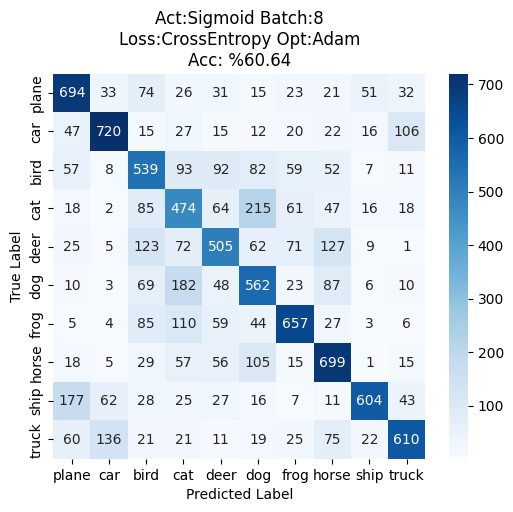


STARTING EXPERIMENT: Act=Sigmoid | Batch=8 | Loss=MSE | Opt=SGD
Epoch 1/10 completed. Loss: 0.0903
Epoch 2/10 completed. Loss: 0.0902
Epoch 3/10 completed. Loss: 0.0902
Epoch 4/10 completed. Loss: 0.0902
Epoch 5/10 completed. Loss: 0.0902
Epoch 6/10 completed. Loss: 0.0902
Epoch 7/10 completed. Loss: 0.0902
Epoch 8/10 completed. Loss: 0.0902
Epoch 9/10 completed. Loss: 0.0902
Epoch 10/10 completed. Loss: 0.0902

--> Experiment Result Accuracy: %10.00


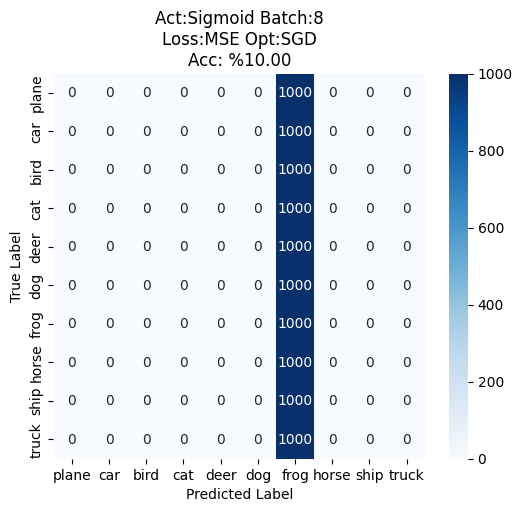


STARTING EXPERIMENT: Act=Sigmoid | Batch=8 | Loss=MSE | Opt=Adam
Epoch 1/10 completed. Loss: 0.0804
Epoch 2/10 completed. Loss: 0.0706
Epoch 3/10 completed. Loss: 0.0654
Epoch 4/10 completed. Loss: 0.0617
Epoch 5/10 completed. Loss: 0.0587
Epoch 6/10 completed. Loss: 0.0563
Epoch 7/10 completed. Loss: 0.0542
Epoch 8/10 completed. Loss: 0.0524
Epoch 9/10 completed. Loss: 0.0507
Epoch 10/10 completed. Loss: 0.0490

--> Experiment Result Accuracy: %58.56


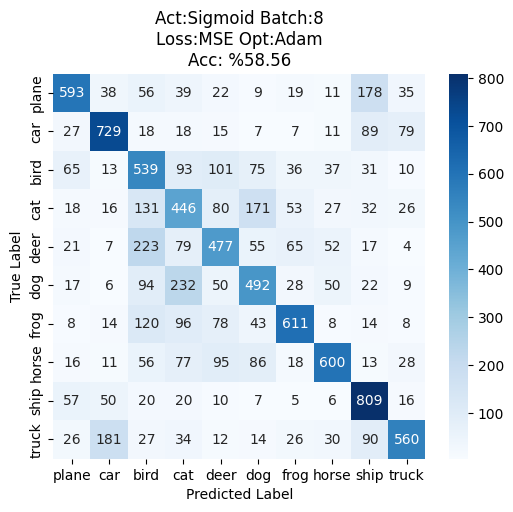


STARTING EXPERIMENT: Act=Sigmoid | Batch=64 | Loss=CrossEntropy | Opt=SGD
Epoch 1/10 completed. Loss: 2.3053
Epoch 2/10 completed. Loss: 2.3035
Epoch 3/10 completed. Loss: 2.3036
Epoch 4/10 completed. Loss: 2.3035
Epoch 5/10 completed. Loss: 2.3035
Epoch 6/10 completed. Loss: 2.3033
Epoch 7/10 completed. Loss: 2.3036
Epoch 8/10 completed. Loss: 2.3035
Epoch 9/10 completed. Loss: 2.3035
Epoch 10/10 completed. Loss: 2.3036

--> Experiment Result Accuracy: %10.00


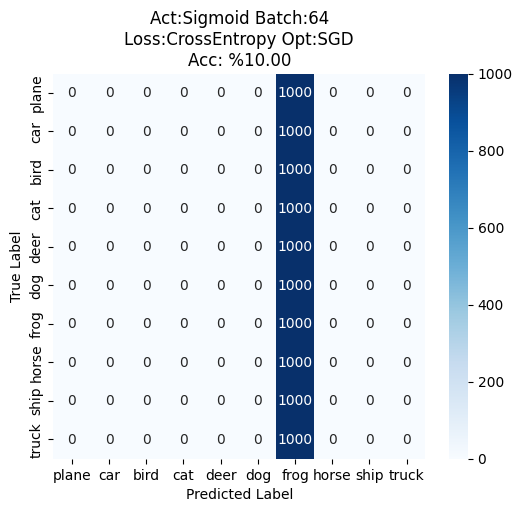


STARTING EXPERIMENT: Act=Sigmoid | Batch=64 | Loss=CrossEntropy | Opt=Adam
Epoch 1/10 completed. Loss: 2.0503
Epoch 2/10 completed. Loss: 1.8615
Epoch 3/10 completed. Loss: 1.6731
Epoch 4/10 completed. Loss: 1.5358
Epoch 5/10 completed. Loss: 1.4612
Epoch 6/10 completed. Loss: 1.4046
Epoch 7/10 completed. Loss: 1.3606
Epoch 8/10 completed. Loss: 1.3224
Epoch 9/10 completed. Loss: 1.2924
Epoch 10/10 completed. Loss: 1.2605

--> Experiment Result Accuracy: %54.60


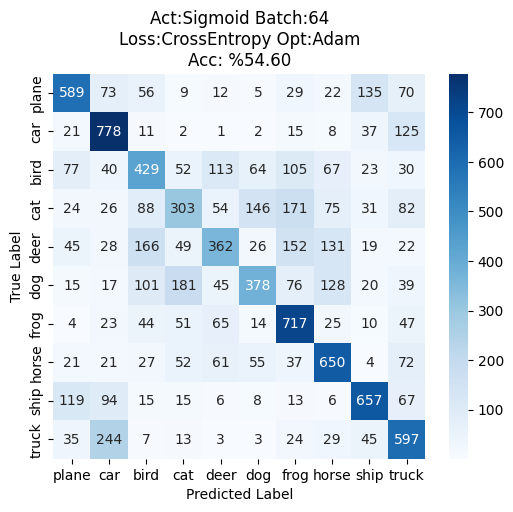


STARTING EXPERIMENT: Act=Sigmoid | Batch=64 | Loss=MSE | Opt=SGD
Epoch 1/10 completed. Loss: 0.0916
Epoch 2/10 completed. Loss: 0.0900
Epoch 3/10 completed. Loss: 0.0900
Epoch 4/10 completed. Loss: 0.0900
Epoch 5/10 completed. Loss: 0.0900
Epoch 6/10 completed. Loss: 0.0900
Epoch 7/10 completed. Loss: 0.0900
Epoch 8/10 completed. Loss: 0.0900
Epoch 9/10 completed. Loss: 0.0900
Epoch 10/10 completed. Loss: 0.0900

--> Experiment Result Accuracy: %10.00


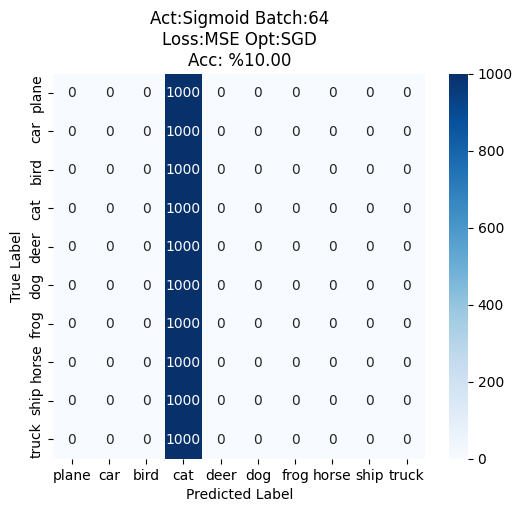


STARTING EXPERIMENT: Act=Sigmoid | Batch=64 | Loss=MSE | Opt=Adam
Epoch 1/10 completed. Loss: 0.0858
Epoch 2/10 completed. Loss: 0.0794
Epoch 3/10 completed. Loss: 0.0735
Epoch 4/10 completed. Loss: 0.0701
Epoch 5/10 completed. Loss: 0.0676
Epoch 6/10 completed. Loss: 0.0657
Epoch 7/10 completed. Loss: 0.0640
Epoch 8/10 completed. Loss: 0.0626
Epoch 9/10 completed. Loss: 0.0610
Epoch 10/10 completed. Loss: 0.0596

--> Experiment Result Accuracy: %54.03


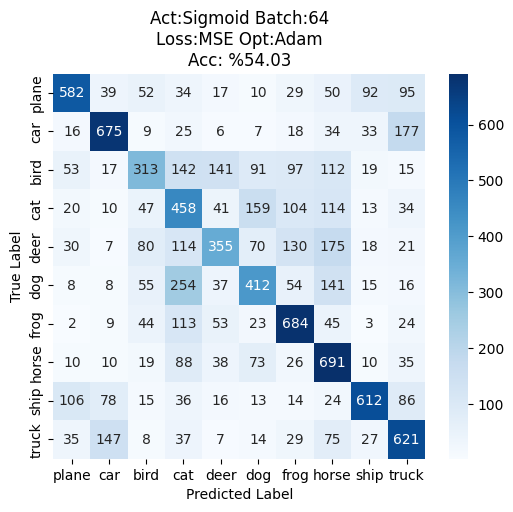

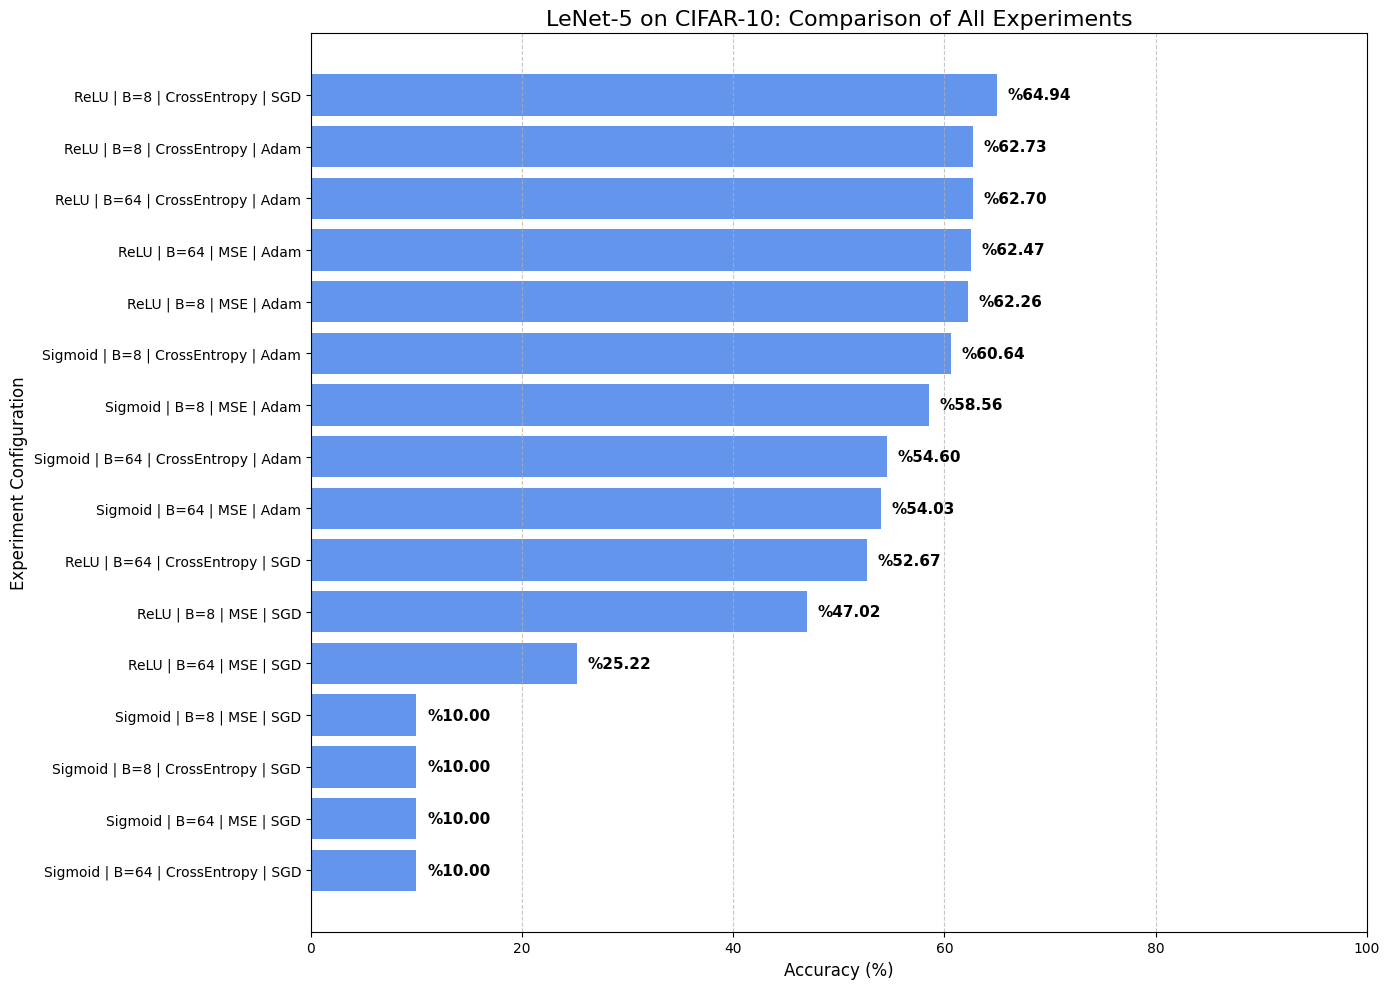

In [ ]:
# Define all parameters to compare
activations = {"ReLU": F.relu, "Sigmoid": torch.sigmoid}
batch_sizes = [8, 64]
losses = {"CrossEntropy": nn.CrossEntropyLoss(), "MSE": nn.MSELoss()}
optimizers = {"SGD": optim.SGD, "Adam": optim.Adam}

# Generate all possible combinations (Cartesian product)
# Total combinations: 2 (Act) * 2 (Batch) * 2 (Loss) * 2 (Opt) = 16 experiments
combinations = list(itertools.product(activations.keys(), batch_sizes, losses.keys(), optimizers.keys()))

results_summary = []

print(f"Total of {len(combinations)} different configurations will be tested.")

# Iterate through every combination
for act_name, batch, loss_name, opt_name in combinations:
    # Run the experiment function
    acc = run_experiment(
        activation_name=act_name,
        activation_fn=activations[act_name],
        batch_size=batch,
        loss_name=loss_name,
        criterion=losses[loss_name],
        optimizer_name=opt_name,
        optimizer_class=optimizers[opt_name],
        epochs=10 # Number of epochs per experiment
    )
    # Save the result for the final graph
    results_summary.append((act_name, batch, loss_name, opt_name, acc))

labels = []
accuracies = []

for act, batch, loss_type, opt, acc in results_summary:
    # Create a descriptive label string for the Y-axis
    label_str = f"{act} | B={batch} | {loss_type} | {opt}"
    labels.append(label_str)
    accuracies.append(acc)

# Sort the results by accuracy (ascending) so the chart looks organized
# This pairs the accuracy with its label, sorts by accuracy, then unzips them back
sorted_data = sorted(zip(accuracies, labels))
accuracies_sorted, labels_sorted = zip(*sorted_data)

# Create the Horizontal Bar Plot
plt.figure(figsize=(14, 10)) # Adjust size to make sure labels fit
bars = plt.barh(labels_sorted, accuracies_sorted, color='cornflowerblue')

# Add titles and axis labels
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Experiment Configuration', fontsize=12)
plt.title('LeNet-5 on CIFAR-10: Comparison of All Experiments', fontsize=16)
plt.xlim(0, 100) # Ensure X-axis goes from 0 to 100
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add the text value at the end of each bar
for bar in bars:
    width = bar.get_width()
    # Place text slightly to the right of the bar end
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f'%{width:.2f}',
             va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()